In [87]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/xlabels_mechanics.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/X_mechanics.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     a_atria   EDP_lv   EDP_rv
0    2.63999  3.00130  4.86389
1    3.15695  5.65473  6.89338
2    4.85812  5.02497  2.16558
3    2.30249  3.45923  3.79267
4    1.47919  2.71888  3.53382
..       ...      ...      ...
995  3.11757  1.13969  5.68550
996  3.06761  3.16270  5.87700
997  3.75881  2.76191  7.32266
998  3.14632  7.38027  6.52224
999  4.39081  5.60215  1.67397

[1000 rows x 3 columns]


In [89]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [90]:
np.sum(mask)

0    86
dtype: int64

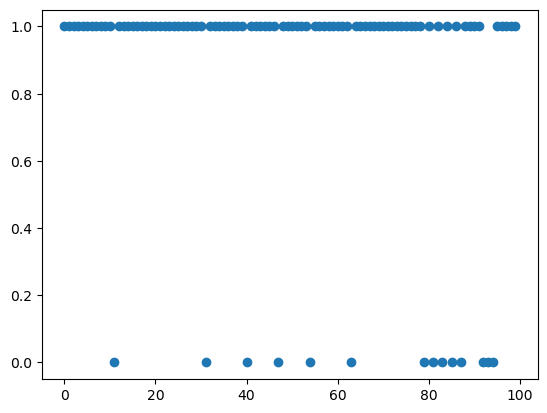

In [91]:
plt.plot(mask,'o')

In [92]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_9/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   170.37   6.11  123.10   98.40       1724       -731  133.90   2.43   
1   155.95   6.67  111.22   95.68       1715       -708  123.70   2.72   
2   151.27   6.13   98.61  107.23       2084       -868  168.51   1.99   
3   164.94   6.04  114.09  104.84       1901       -809  148.64   2.32   
4   170.57   6.01  119.41  105.08       1878       -801  149.27   2.33   
..     ...    ...     ...     ...        ...        ...     ...    ...   
81  142.62   6.56   91.56  106.81       2124       -866  155.57   2.39   
82  157.79   5.99  105.72  106.91       2013       -851  156.92   2.18   
83  151.64   6.34  103.12  102.21       1909       -793  138.84   2.52   
84  153.82   6.84  109.21   95.85       1727       -709  122.45   2.82   
85  170.37   6.06  120.99  102.11       1808       -768  141.84   2.40   

     RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0    89.29   24.49  ...   90.30    3.0

In [93]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [95]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [96]:
model.fit(input_masked.values, mask.values.squeeze())

LogisticRegression(random_state=0, solver='liblinear')

In [97]:
reps=50
fail_score = 0
success_score = 0

for j in range(reps):
    complete_input_train=input_complete.sample(12)
    complete_output_train=mask.loc[complete_input_train.index]
    complete_input_test = input_complete.loc[~input_complete.index.isin(complete_input_train.index)]
    complete_output_test = mask.loc[complete_input_test.index]
    for i in range(input_failed.shape[0]):
   
        fail_input_test = input_failed.iloc[[i]]
        fail_output_test = mask.loc[fail_input_test.index]
        fail_input_train=input_failed.loc[~input_failed.index.isin(fail_input_test.index)]
        fail_output_train=mask.loc[fail_input_train.index]

        y_train = pd.concat([fail_output_train,complete_output_train])
        y_test = pd.concat([fail_output_test,complete_output_test])

        x_train = pd.concat([fail_input_train,complete_input_train])
        x_test= pd.concat([fail_input_test,complete_input_test])

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train.values, y_train.values.squeeze())

        success_score+=(1-model.predict(fail_input_test.values))/input_failed.shape[0]/reps
        fail_score+=model.score(complete_input_test.values,complete_output_test.values.squeeze())/reps/input_failed.shape[0]

In [98]:
success_score

array([0.92857143])

In [99]:
fail_score

0.786312741312743

In [100]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(x_train.iloc[:,i]),np.max(x_train.iloc[:,i])])
    print(boundsMaxMin[i])
    

[1.1092, 3.98449]
[1.03793, 6.74436]
[2.07143, 7.36389]


In [101]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = param_values
#data1.columns = X_train.columns

Ymean=model.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_48529/2588839841.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [102]:
Ymean.shape

(8192,)

In [103]:
np.sum(Ymean)

5502

In [104]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean, print_to_console=True,calc_second_order=True))

                  ST   ST_conf
(a_atria,)  0.662944  0.065061
(EDP_lv,)   0.070714  0.022307
(EDP_rv,)   0.693881  0.061824
                  S1   S1_conf
(a_atria,)  0.298886  0.070177
(EDP_lv,)   0.002903  0.021187
(EDP_rv,)   0.301920  0.066919
Empty DataFrame
Columns: [S2, S2_conf]
Index: []


In [105]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

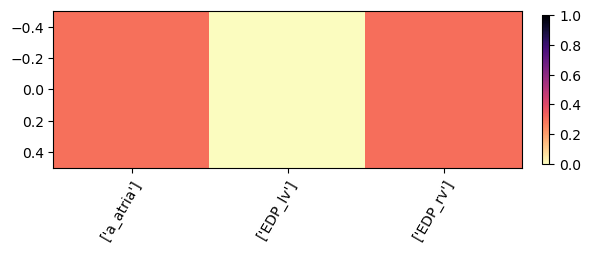

In [106]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

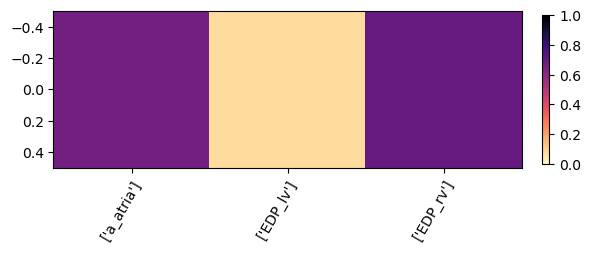

In [107]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [108]:
np.max(data1[:,2])

7.361305791015624

In [109]:
data2=data1[::20]

Text(0.5, 0, 'EDP_lv')

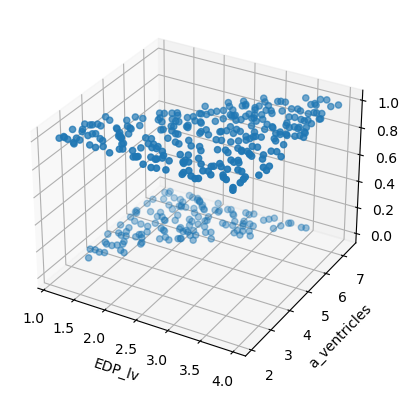

In [110]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data2[:,0],data2[:,2],model.predict(data2))
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

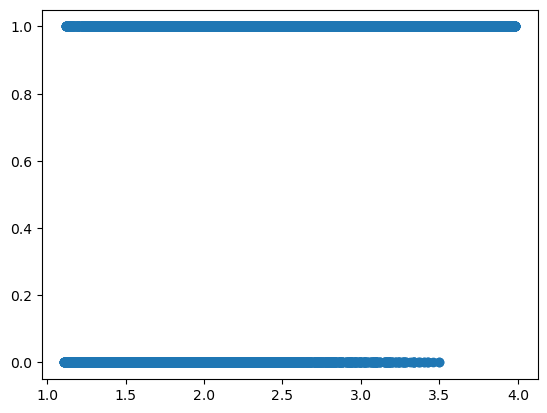

In [111]:
plt.plot(data1[:,0],model.predict(data1),'o')

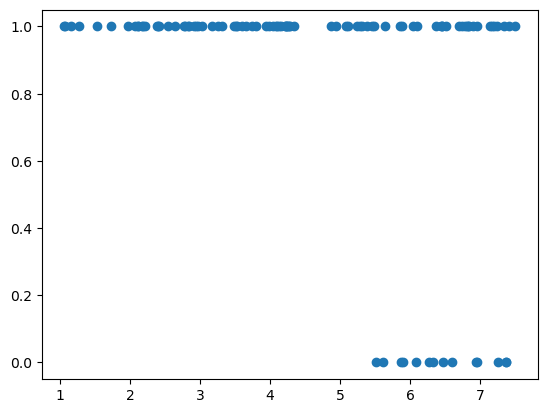

In [112]:
plt.plot(input_masked.iloc[:,2],mask,'o')

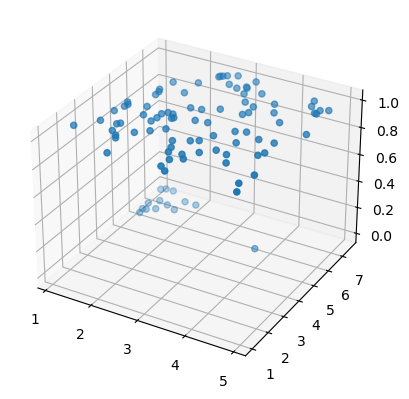

In [113]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(input_masked.iloc[:,0],input_masked.iloc[:,2],mask)

# Emulator

In [114]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [115]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [116]:
input_masked.shape

(86, 3)

In [117]:
y_all.shape

(86, 28)

In [118]:
y_all.index[0]

0

In [119]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,170.37,6.11,123.10,98.40,1724,-731,133.90,2.43,89.29,24.49,...,90.30,3.06,18.39,9.17,13.04,11.63,10.42,12.61,95.661,117.639
1,155.95,6.67,111.22,95.68,1715,-708,123.70,2.72,82.98,24.11,...,86.32,3.26,15.31,8.11,11.79,10.19,9.07,10.48,95.305,119.839
2,151.27,6.13,98.61,107.23,2084,-868,168.51,1.99,116.20,26.11,...,104.06,2.72,13.72,10.27,12.61,11.17,11.82,12.85,94.873,115.533
3,164.94,6.04,114.09,104.84,1901,-809,148.64,2.32,99.33,25.39,...,95.49,3.07,19.38,10.28,14.47,13.13,12.04,14.51,95.199,116.638
4,170.57,6.01,119.41,105.08,1878,-801,149.27,2.33,99.34,25.39,...,93.78,3.12,22.85,10.35,15.26,14.23,12.70,16.14,95.636,116.407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,142.62,6.56,91.56,106.81,2124,-866,155.57,2.39,105.93,25.66,...,99.50,3.14,16.30,9.98,13.63,13.16,12.60,14.54,93.362,116.897
82,157.79,5.99,105.72,106.91,2013,-851,156.92,2.18,105.98,25.74,...,100.15,2.93,16.34,10.45,13.80,12.31,12.10,13.80,94.408,116.117
83,151.64,6.34,103.12,102.21,1909,-793,138.84,2.52,93.11,25.06,...,92.94,3.15,14.84,9.22,12.51,11.01,10.08,11.39,94.592,117.728
84,153.82,6.84,109.21,95.85,1727,-709,122.45,2.82,81.99,24.18,...,83.28,3.34,15.56,8.29,12.44,10.08,9.15,10.72,94.885,120.042


In [120]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [121]:
y_train

tensor([[170.3700,   6.1100, 123.1000,  ...,  12.6100,  95.6610, 117.6390],
        [155.9500,   6.6700, 111.2200,  ...,  10.4800,  95.3050, 119.8390],
        [151.2700,   6.1300,  98.6100,  ...,  12.8500,  94.8730, 115.5330],
        ...,
        [151.6400,   6.3400, 103.1200,  ...,  11.3900,  94.5920, 117.7280],
        [153.8200,   6.8400, 109.2100,  ...,  10.7200,  94.8850, 120.0420],
        [170.3700,   6.0600, 120.9900,  ...,  14.3100,  95.7200, 117.1170]],
       dtype=torch.float64)

In [122]:
x_train.shape

torch.Size([86, 3])

In [123]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [124]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[1.1476, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]


In [125]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_48529/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [126]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                  ST   ST_conf
(a_atria,)  0.006524  0.000801
(EDP_lv,)   0.929851  0.060424
(EDP_rv,)   0.067415  0.006163
                  S1   S1_conf
(a_atria,)  0.005382  0.007599
(EDP_lv,)   0.926952  0.068848
(EDP_rv,)   0.063521  0.018903
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.102501  0.009778
(EDP_lv,)   0.605399  0.062772
(EDP_rv,)   0.433219  0.042147
                  S1   S1_conf
(a_atria,)  0.097177  0.030320
(EDP_lv,)   0.468655  0.070468
(EDP_rv,)   0.291578  0.056115
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.001661  0.000150
(EDP_lv,)   0.778750  0.050513
(EDP_rv,)   0.229878  0.022122
                  S1   S1_conf
(a_atria,)  0.001510  0.004001
(EDP_lv,)   0.768772  0.054096
(EDP_rv,)   0.219627  0.042631
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.017812  0.001858
(EDP_lv,)   0.198594  0.021706
(EDP_rv,)   0.83

In [127]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


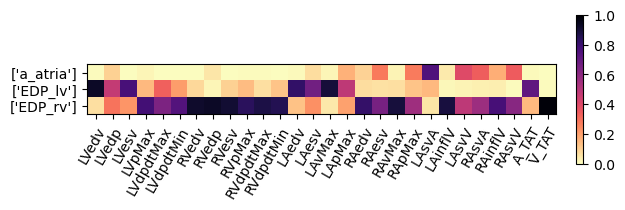

In [128]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

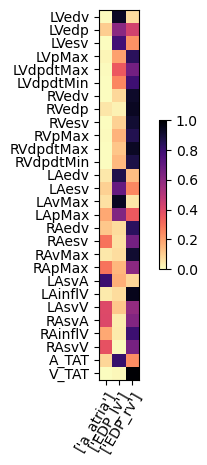

In [129]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [130]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,170.37,6.11,123.10,98.40,1724,-731,133.90,2.43,89.29,24.49,...,90.30,3.06,18.39,9.17,13.04,11.63,10.42,12.61,95.661,117.639
1,155.95,6.67,111.22,95.68,1715,-708,123.70,2.72,82.98,24.11,...,86.32,3.26,15.31,8.11,11.79,10.19,9.07,10.48,95.305,119.839
2,151.27,6.13,98.61,107.23,2084,-868,168.51,1.99,116.20,26.11,...,104.06,2.72,13.72,10.27,12.61,11.17,11.82,12.85,94.873,115.533
3,164.94,6.04,114.09,104.84,1901,-809,148.64,2.32,99.33,25.39,...,95.49,3.07,19.38,10.28,14.47,13.13,12.04,14.51,95.199,116.638
4,170.57,6.01,119.41,105.08,1878,-801,149.27,2.33,99.34,25.39,...,93.78,3.12,22.85,10.35,15.26,14.23,12.70,16.14,95.636,116.407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,142.62,6.56,91.56,106.81,2124,-866,155.57,2.39,105.93,25.66,...,99.50,3.14,16.30,9.98,13.63,13.16,12.60,14.54,93.362,116.897
82,157.79,5.99,105.72,106.91,2013,-851,156.92,2.18,105.98,25.74,...,100.15,2.93,16.34,10.45,13.80,12.31,12.10,13.80,94.408,116.117
83,151.64,6.34,103.12,102.21,1909,-793,138.84,2.52,93.11,25.06,...,92.94,3.15,14.84,9.22,12.51,11.01,10.08,11.39,94.592,117.728
84,153.82,6.84,109.21,95.85,1727,-709,122.45,2.82,81.99,24.18,...,83.28,3.34,15.56,8.29,12.44,10.08,9.15,10.72,94.885,120.042


In [131]:
y_train

tensor([[170.3700,   6.1100, 123.1000,  ...,  12.6100,  95.6610, 117.6390],
        [155.9500,   6.6700, 111.2200,  ...,  10.4800,  95.3050, 119.8390],
        [151.2700,   6.1300,  98.6100,  ...,  12.8500,  94.8730, 115.5330],
        ...,
        [151.6400,   6.3400, 103.1200,  ...,  11.3900,  94.5920, 117.7280],
        [153.8200,   6.8400, 109.2100,  ...,  10.7200,  94.8850, 120.0420],
        [170.3700,   6.0600, 120.9900,  ...,  14.3100,  95.7200, 117.1170]],
       dtype=torch.float64)

In [132]:
y_all.copy().drop(y_all.index[i]).values

array([[170.37 ,   6.11 , 123.1  , ...,  12.61 ,  95.661, 117.639],
       [155.95 ,   6.67 , 111.22 , ...,  10.48 ,  95.305, 119.839],
       [151.27 ,   6.13 ,  98.61 , ...,  12.85 ,  94.873, 115.533],
       ...,
       [151.64 ,   6.34 , 103.12 , ...,  11.39 ,  94.592, 117.728],
       [153.82 ,   6.84 , 109.21 , ...,  10.72 ,  94.885, 120.042],
       [170.37 ,   6.06 , 120.99 , ...,  14.31 ,  95.72 , 117.117]])

In [133]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = torch.tensor(y_all.copy().drop(y_all.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_all.index[i]).values)
    
    y_test = torch.tensor(y_all.loc[[y_all.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_all.index[i]]].values)
    
    
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [135]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

LVedv        0.998914
LVedp        0.997581
LVesv        0.999163
LVpMax       0.998013
LVdpdtMax    0.999091
LVdpdtMin    0.998619
RVedv        0.998918
RVedp        0.999240
RVesv        0.998825
RVpMax       0.996814
RVdpdtMax    0.995285
RVdpdtMin    0.997377
LAedv        0.998306
LAesv        0.997524
LAvMax       0.998385
LApMax       0.995887
RAedv        0.999351
RAesv        0.999125
RAvMax       0.999339
RApMax       0.998221
LAsvA        0.994656
LAinflV      0.996128
LAsvV        0.998326
RAsvA        0.998079
RAinflV      0.999653
RAsvV        0.999626
A_TAT        0.954582
V_TAT        0.986729
dtype: float64

In [136]:
MSE.shape

(86, 28)

In [137]:
MSE[0].shape

(28,)

In [138]:
np.var(y_all,axis=0).shape

(28,)

In [139]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

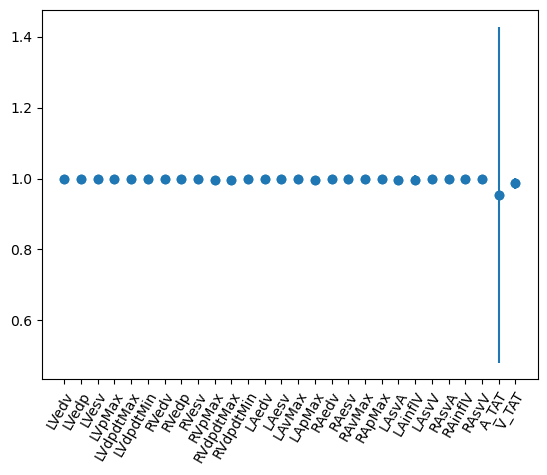

In [140]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [68]:
y_calibration2=y_calibration.join(y_calibration2)

In [69]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = torch.tensor(y_calibration.copy().drop(y_calibration.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_calibration.index[i]).values)
    
    y_test = torch.tensor(y_calibration.loc[[y_calibration.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_calibration.index[i]]].values)
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

tensor([[117.6390,  95.6610,  98.4000, 170.3700, 123.1000]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[119.8390,  95.3050,  95.6800, 155.9500, 111.2200]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[115.5330,  94.8730, 107.2300, 151.2700,  98.6100]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[116.6380,  95.1990, 104.8400, 164.9400, 114.0900]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[116.4070,  95.6360, 105.0800, 170.5700, 119.4100]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[119.8610,  94.7860,  97.0300, 149.7800, 104.7200]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[118.2660,  96.3590,  93.2100, 178.1600, 133.4300]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[115.4210,  94.6560, 108.4300, 151.8700,  98.4000]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[115.3010,  94.7540, 108.3900, 152.5600,  99.2200]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[114.5330,  95.8550, 107.2100, 176.4700, 122.7100]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[1

1
2
3
4
tensor([[117.7280,  94.5920, 102.2100, 151.6400, 103.1200]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[120.0420,  94.8850,  95.8500, 153.8200, 109.2100]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[117.1170,  95.7200, 102.1100, 170.3700, 120.9900]],
       dtype=torch.float64)
0
1
2
3
4


In [70]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [71]:
R2.std(axis=0)

array([0.01533567, 0.47340388, 0.00136058, 0.00085291, 0.0006014 ])

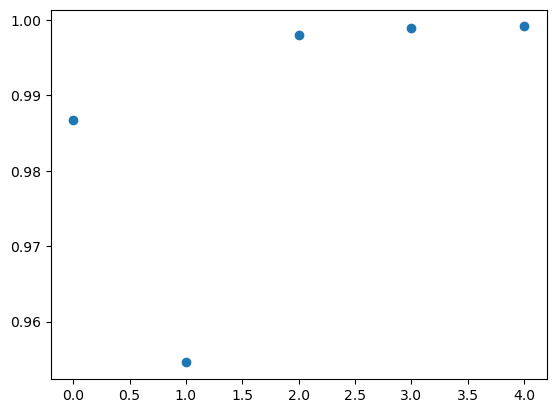

In [72]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [73]:
y_calibration.columns.values.tolist()

['V_TAT', 'A_TAT', 'LVpMax', 'LVedv', 'LVesv']

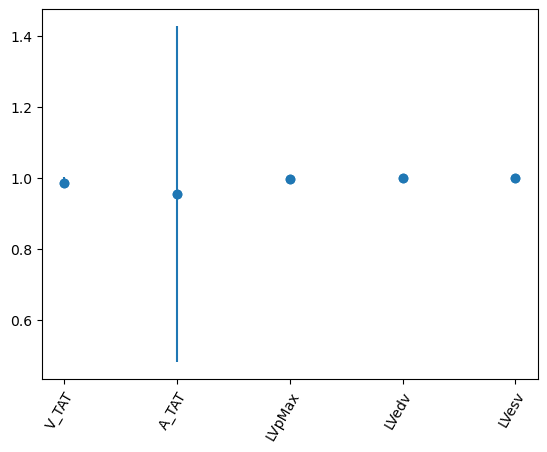

In [74]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [75]:
X_train = torch.tensor(input_masked.values)

In [76]:
y_train=torch.tensor(y_calibration.values)

In [77]:
X_train

tensor([[2.6400, 3.0013, 4.8639],
        [3.1570, 5.6547, 6.8934],
        [4.8581, 5.0250, 2.1656],
        [2.3025, 3.4592, 3.7927],
        [1.4792, 2.7189, 3.5338],
        [2.5187, 6.8159, 7.2425],
        [4.9605, 1.7581, 5.1088],
        [3.2997, 5.1914, 1.7326],
        [3.5008, 5.0080, 1.9661],
        [3.2931, 1.0561, 1.2706],
        [1.8278, 1.4077, 6.0955],
        [4.0628, 7.2747, 5.8532],
        [2.2394, 4.8291, 2.6465],
        [2.7631, 6.8230, 7.4999],
        [4.8768, 4.4200, 1.0636],
        [3.6255, 4.6276, 2.5384],
        [2.9895, 6.6539, 6.7328],
        [4.0169, 1.3145, 3.6045],
        [3.8438, 1.4008, 2.9114],
        [3.3987, 5.2197, 6.0382],
        [4.8908, 3.1685, 6.8257],
        [3.2189, 4.1111, 6.5087],
        [3.5349, 6.7192, 3.6528],
        [2.4534, 4.5087, 2.9676],
        [3.5914, 4.9239, 5.2801],
        [3.7936, 2.7702, 4.2089],
        [2.2218, 2.7352, 1.1609],
        [1.7588, 5.8424, 5.4604],
        [3.1248, 1.4211, 6.9546],
        [4.756

In [78]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4


In [79]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(X_train[:,i]).detach().numpy(),torch.max(X_train[:,i]).detach().numpy()])
    print(boundsMaxMin[i])

[array(1.1476), array(4.96054)]
[array(1.05607), array(7.27469)]
[array(1.06364), array(7.4999)]


In [80]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_48529/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [81]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                  ST   ST_conf
(a_atria,)  0.002342  0.000331
(EDP_lv,)   0.014096  0.001635
(EDP_rv,)   0.994749  0.062196
                  S1   S1_conf
(a_atria,)  0.001748  0.004827
(EDP_lv,)   0.003980  0.010642
(EDP_rv,)   0.984008  0.069087
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.085709  0.012934
(EDP_lv,)   0.804853  0.074107
(EDP_rv,)   0.240659  0.026622
                  S1   S1_conf
(a_atria,)  0.009782  0.026774
(EDP_lv,)   0.709059  0.072684
(EDP_rv,)   0.145693  0.042610
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.017872  0.001826
(EDP_lv,)   0.198506  0.018401
(EDP_rv,)   0.837387  0.062320
                  S1   S1_conf
(a_atria,)  0.016456  0.012252
(EDP_lv,)   0.145642  0.039922
(EDP_rv,)   0.779786  0.063213
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                  ST   ST_conf
(a_atria,)  0.006566  0.000682
(EDP_lv,)   0.929748  0.062625
(EDP_rv,)   0.06

In [82]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


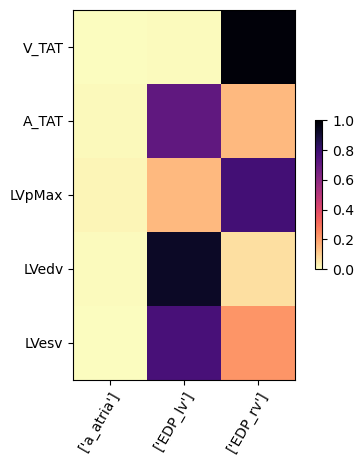

In [83]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

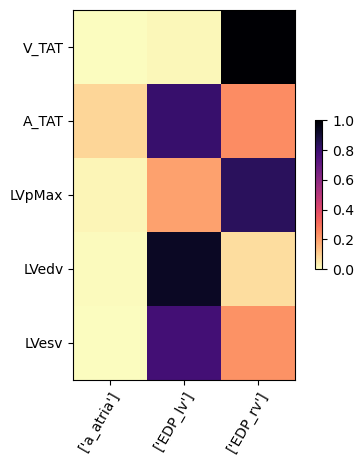

In [84]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [85]:
emulator.predict(data1).detach().numpy()[:,4]

array([115.87263, 114.8215 , 107.59082, ..., 109.32188, 117.3281 ,
       109.18952], dtype=float32)

IndexError: index 4 is out of bounds for dimension 1 with size 3

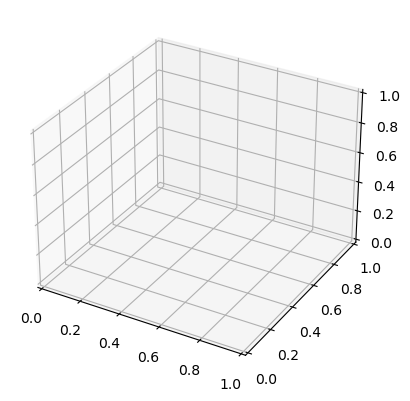

In [86]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1[:,4],data1[:,6],emulator.predict(data1).detach().numpy()[:,3])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [ ]:
Si[i].to_df()

In [ ]:
y_calibration

In [ ]:
y_calibration = y_all.loc[:,['V_TAT','A_TAT','LVpMax','LVedv']]

In [ ]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [ ]:
y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)

In [ ]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

In [ ]:
input_masked

In [ ]:
boundsMaxMin

In [ ]:
boundsMaxMin

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = torch.tensor([100,134,157,111,0.8])

In [ ]:
boundsMaxMin

In [ ]:
np.array(boundsMaxMin)[:,0]*2

In [ ]:
p0[0]

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [ ]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0).detach().numpy())

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0)).detach().numpy())
    return ll

In [ ]:
log_likelihood(p0[1],emulator,y_val)

In [ ]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
p0[i].shape

In [ ]:
torch.tensor(p0[0]).shape

In [ ]:
emulator.predict(torch.tensor(p0)).shape

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_50_4timesUpper.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [ ]:
y_calibration.columns

In [ ]:
x_out.shape

In [ ]:
emulator.predict(x_out[None,:])

In [ ]:
torch.tensor(flat_samples.T).shape

In [ ]:
plt.hist(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
working = model.predict(flat_samples)

In [ ]:
plt.plot(working,'o')

# Calibration with fixed inputs

In [ ]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [ ]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

In [ ]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
nDim

In [ ]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.5]

In [ ]:
x_labels.values.squeeze().tolist()

In [ ]:
new_input.columns

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = new_input.columns.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
sampler.run_mcmc(p0, 30000)

In [ ]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = new_input.columns.values.squeeze()

In [ ]:
y_calibration.columns

In [ ]:
emulator.predict(x_out)

In [ ]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Multi-Output GP

In [ ]:
import mogptk

In [ ]:
y_calibration

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration2.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

In [ ]:
emulator.MSE(X_test,y_test)

In [ ]:
model.plot_correlation()

In [ ]:
model.print_parameters()

In [ ]:
params?

In [ ]:
params = []

for p in model.parameters():
    params.append(p)

In [ ]:
params

In [ ]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

In [ ]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
model.plot_correlation()

In [ ]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [ ]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test

In [ ]:
import cigp_v10 as cig

In [ ]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [ ]:
import time
start = time.time()


model.train_adam(niteration=500)



In [ ]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

In [ ]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [ ]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

In [ ]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
np.var(y_test,axis=0)

In [ ]:
y_all.iloc[:,[4]].max()

In [ ]:
y_all.iloc[:,[4]].min()

In [ ]:
y_all.iloc[:,[4]].std()